# Figure 2: change detection CGFs

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf

import torch

## General figure formatting

In [2]:
figsize(1.5,1.5)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rc('font', size=10)
plt.rc('lines', linewidth=1.8)
plt.rcParams['text.usetex'] = True

## Load balanced MNIST model

In [3]:
from change_detection import RateFunctionTest, ScoreTest

from cgf_network import CGF_ICNN, ConditionalCGF
from models.simple_examples import Basic_MNIST
from models.data_utilities import exact_data_ratios


from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from functools import partial

# model checkpoints
classifier_ckpt = './learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'
conditional_ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'



# load MNIST data 
mnist_train_data = MNIST('~/Datasets/', download=True, train=True,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )

mnist_test_data = MNIST('~/Datasets/', download=True, train=False,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )


mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
train_like, _ = exact_data_ratios(mnist_train_data)
mnist_model.fit_activity_transform(train_like)

activity_dataset_train = mnist_model.internal_activity_dataset(train_like)
activity_dataset_test = mnist_model.internal_activity_dataset(mnist_test_data)


mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_dataset_train[:][0])
conditional_mnist = ConditionalCGF.load_from_checkpoint(conditional_ckpt,
                                                        dataset_to_model=activity_dataset_train)

## ROC curves

In [4]:
# Change detection functions

def limiting_neg_log_density(mus):
    """ Model based asymptotic pdf of the mean """
    d = 28
    n_samples = 100

    thetas, Is = mnist_cgf.dual_opt(mus)
    logdets = torch.logdet(mnist_cgf.hess(thetas))
    
    return  0.5*logdets + n_samples*Is

activity_mean = activity_dataset_train[:][0].mean(0)
activity_cov =  1./100 * activity_dataset_train[:][0].T.cov()
inv_cov = torch.linalg.inv(activity_cov)

def normal_score(means):
    distance_to_mean = means - activity_mean
    return torch.einsum('Nx, xy, Ny -> N', distance_to_mean, inv_cov, distance_to_mean)


from torch.distributions import Multinomial

def theoretical_max(targets):
    """ Uses ground truth targets to determine theoretical best ROC curves """
    probs = torch.ones(10) / 10.
    multinom = Multinomial(total_count=targets.shape[1], probs=1./ 10 * torch.ones(10))

    counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)
    return -multinom.log_prob(counts)



In [5]:
# evaluation functions

def sample_means(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity.mean(1), targets

def make_ROC(scores_plus, scores_minus):
    """ ROC plots for scores """
    min_score = min([scores_plus.min(), scores_minus.min()])
    max_score = max([scores_plus.max(), scores_minus.max()])
    
    true_plus = []
    false_plus = []
    
    for score_threashold in np.linspace(min_score, max_score, 500):
        true_plus.append( (scores_plus < score_threashold).sum() / scores_plus.shape[0])
        false_plus.append( (scores_minus < score_threashold).sum() / scores_minus.shape[0])
        
    return true_plus, false_plus

from torchmetrics import AUROC

def compute_auROC(detection_function, pos_means, neg_means):
    """ computes the auROC for a given detection_function, where rejection occurs if the
        output is greater than some threashold 
    """
    pos_outputs = detection_function(pos_means).detach()
    neg_outputs = detection_function(neg_means).detach()

    # convert into 'probability-like' points, ranging from 0 to 1
    preds = torch.concat([pos_outputs, neg_outputs])
    targets = torch.concat([torch.ones_like(pos_outputs), torch.zeros_like(neg_outputs)])

    preds = 1 - (preds - preds.min()) / (preds.max() - preds.min())

    auroc = AUROC(task='binary')
    return auroc(preds, targets)


In [6]:
figsize(4,4)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


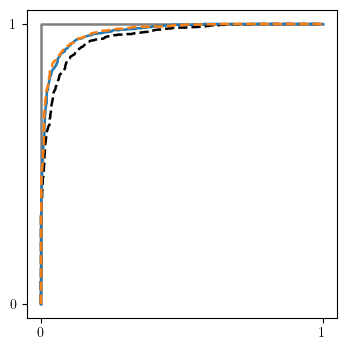

In [7]:
means, targets = sample_means(activity_dataset_test, 100, 1000)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 0
alt_weights[8] = 0
means_alternate, targets_alternate = sample_means(activity_dataset_test, 100, 1000, target_weights=alt_weights)

figsize(4,4)
true_best, false_best = make_ROC(theoretical_max(targets), theoretical_max(targets_alternate))
plt.plot(false_best, true_best, 'grey', label='theoretical max')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k', label='score test')

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate, label='rate function')

true_prob, false_prob = make_ROC(limiting_neg_log_density(means).detach(), limiting_neg_log_density(means_alternate).detach())
plt.plot(false_prob, true_prob, '--', label='approximate density')

plt.xticks([0., 1.])
plt.yticks([0., 1.]);

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


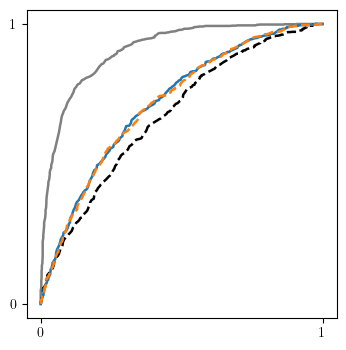

In [8]:
n_mean = 100

means, targets = sample_means(activity_dataset_test, n_mean, 1000)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 2
alt_weights[8] = 2
means_alternate, targets_alternate = sample_means(activity_dataset_test, n_mean, 1000, target_weights=alt_weights)

figsize(4,4)
true_best, false_best = make_ROC(theoretical_max(targets), theoretical_max(targets_alternate))
plt.plot(false_best, true_best, 'grey', label='theoretical max')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k', label='score test')

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate, label='rate function')

true_prob, false_prob = make_ROC(limiting_neg_log_density(means).detach(), limiting_neg_log_density(means_alternate).detach())
plt.plot(false_prob, true_prob, '--', label='approximate density')

plt.xticks([0., 1.])
plt.yticks([0., 1.]);

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


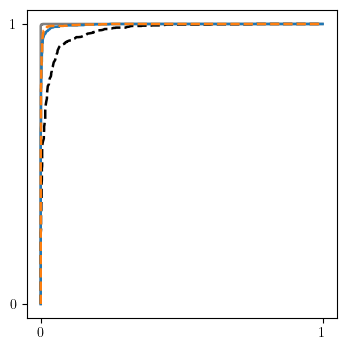

In [9]:
n_mean = 1000

means, targets = sample_means(activity_dataset_test, n_mean, 1000)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
means_alternate, targets_alternate = sample_means(activity_dataset_test, n_mean, 1000, target_weights=alt_weights)

figsize(4,4)
true_best, false_best = make_ROC(theoretical_max(targets), theoretical_max(targets_alternate))
plt.plot(false_best, true_best, 'grey', label='theoretical max')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k', label='score test')

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate, label='rate function')

true_prob, false_prob = make_ROC(limiting_neg_log_density(means).detach(), limiting_neg_log_density(means_alternate).detach())
plt.plot(false_prob, true_prob, '--', label='approximate density')

plt.xticks([0., 1.])
plt.yticks([0., 1.]);

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


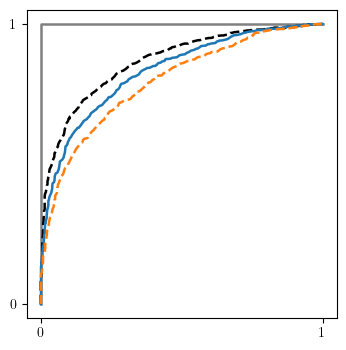

In [10]:
n_mean = 100

means, targets = sample_means(activity_dataset_test, n_mean, 1000)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
means_alternate, targets_alternate = sample_means(activity_dataset_test, n_mean, 1000, target_weights=alt_weights)

figsize(4,4)
true_best, false_best = make_ROC(theoretical_max(targets), theoretical_max(targets_alternate))
plt.plot(false_best, true_best, 'grey', label='theoretical max')

true_norm, false_norm = make_ROC(normal_score(means), normal_score(means_alternate))
plt.plot(false_norm, true_norm, '--k', label='score test')

true_rate, false_rate = make_ROC(mnist_cgf.dual_function(means).detach(), mnist_cgf.dual_function(means_alternate).detach())
plt.plot(false_rate, true_rate, label='rate function')

true_prob, false_prob = make_ROC(limiting_neg_log_density(means).detach(), limiting_neg_log_density(means_alternate).detach())
plt.plot(false_prob, true_prob, '--', label='approximate density')

plt.xticks([0., 1.])
plt.yticks([0., 1.]);

In [11]:
compute_auROC(theoretical_max, targets, targets_alternate)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


tensor(1.)

In [12]:
def auROC_across_models(n_mean, alt_weights):
    n_samples = 1000
    if n_mean < 100:
        n_samples = 5000

    means, targets = sample_means(activity_dataset_test, n_mean, n_samples)
    means_alternate, targets_alternate = sample_means(activity_dataset_test, n_mean, n_samples, target_weights=alt_weights)

    maxAUC = compute_auROC(theoretical_max, targets, targets_alternate)
    rateAUC = compute_auROC(mnist_cgf.dual_function, means, means_alternate)
    densityAUC = compute_auROC(limiting_neg_log_density, means, means_alternate)
    normAUC = compute_auROC(normal_score, means, means_alternate)

    return (maxAUC, rateAUC, densityAUC, normAUC)

In [13]:
distributions = []

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 2
alt_weights[8] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[0] = 1.5
alt_weights[1] = 1.5
alt_weights[2] = 1.5
alt_weights[3] = 1.5
alt_weights[4] = 1.5

distributions.append(alt_weights)

means = [10, 30, 50, 100, 300, 500, 1000]

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


(0.5, 1.0)

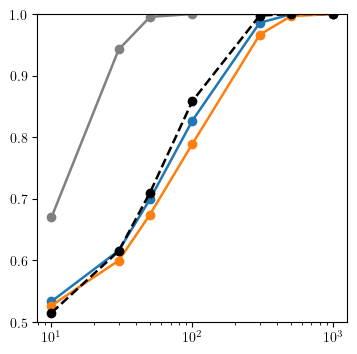

In [14]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[0]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.])

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


(0.5, 1.0)

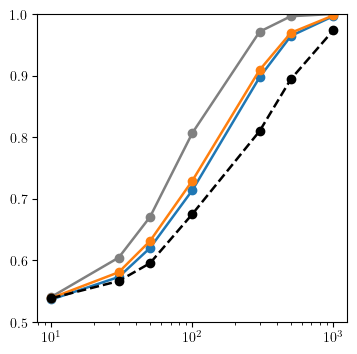

In [15]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[1]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.])

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


(0.5, 1.0)

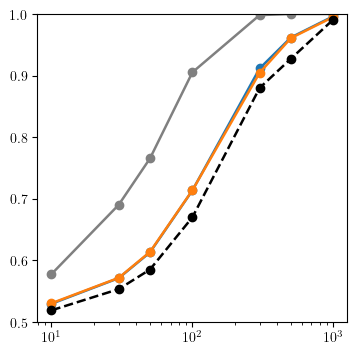

In [16]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[2]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.])

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


(0.5, 1.0)

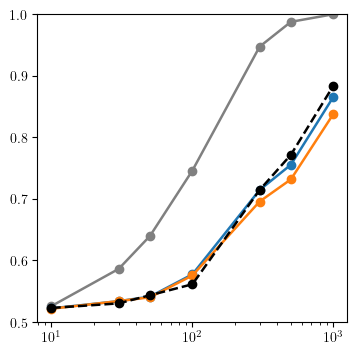

In [17]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[3]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.])

## Ok, we have our figures.

### Legend

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


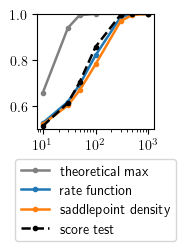

In [76]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[0]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o', label='theoretical max')
plt.semilogx(means, ROC_curves[1], marker='o', label='rate function')
plt.semilogx(means, ROC_curves[2], marker='o', label='saddlepoint density')
plt.semilogx(means, ROC_curves[3], '--k', marker='o', label='score test')

plt.ylim([0.5, 1.])
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=1);
plt.savefig('legend.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

In [57]:
figsize(1.5,1.5)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rc('font', size=10)
plt.rc('lines', linewidth=1.8, markersize=3)
plt.rcParams['text.usetex'] = True

### histograms

In [47]:
figsize(1.5,0.5)
plt.rc('axes.spines', **{'bottom':True, 'left':False, 'right':False, 'top':False})

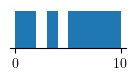

In [48]:
plt.hist(distributions[0].keys(), weights=distributions[0].values(), bins=range(11), density=True);
plt.yticks([]);
plt.savefig('hist1.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

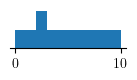

In [49]:
plt.hist(distributions[1].keys(), weights=distributions[1].values(), bins=range(11), density=True);
plt.yticks([]);
plt.savefig('hist2.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

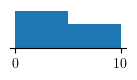

In [50]:
plt.hist(distributions[3].keys(), weights=distributions[3].values(), bins=range(11), density=True);
plt.yticks([]);
plt.savefig('hist3.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

### auROC curves

In [72]:
figsize(1.5,1.5)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


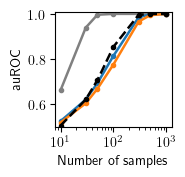

In [73]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[0]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.01])
plt.ylabel('auROC')
plt.xlabel('Number of samples')
plt.savefig('auroc1.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


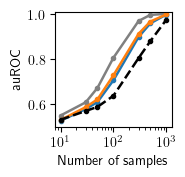

In [74]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[1]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.01])
plt.ylabel('auROC')
plt.xlabel('Number of samples')
plt.savefig('auroc2.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_46719/468487976.py:29: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.func.vmap(lambda row: torch.bincount(row, minlength=10))(targets)


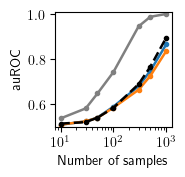

In [75]:
ROC_curves = list(map( lambda m: auROC_across_models(m, distributions[3]), means))
ROC_curves = torch.tensor(list(zip(*ROC_curves)))


plt.semilogx(means, ROC_curves[0], 'grey', marker='o')
plt.semilogx(means, ROC_curves[1], marker='o')
plt.semilogx(means, ROC_curves[2], marker='o')
plt.semilogx(means, ROC_curves[3], '--k', marker='o')

plt.ylim([0.5, 1.01])
plt.ylabel('auROC')
plt.xlabel('Number of samples')
plt.savefig('auroc3.png', dpi=1000, bbox_inches='tight', pad_inches=0.02)